In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import warnings
warnings.filterwarnings("ignore")
from random import randint
from scipy.signal import correlate
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import r2_score
from statsmodels.formula.api import ols
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,cross_val_predict

In [2]:
from sklearn.ensemble import GradientBoostingRegressor

/Users/ismail/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
df_train = pd.read_csv('train.csv',index_col='Id')
df_test = pd.read_csv('test.csv',index_col='Id')
# combine train and test datas in to one dataframe
df_all = pd.concat([df_train,df_test], sort=True)
df_all.head(2)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
2,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007


In [4]:
# check NaN 
cols_with_na = df_all.drop('SalePrice',axis=1).isnull().sum()
cols_with_na = cols_with_na[cols_with_na>0]
print(cols_with_na.sort_values(ascending=False))

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageArea         1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
dtype: int64


In [5]:

df_all[df_all['TotalBsmtSF'].isnull()]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
2121,896,0,0,NaN,2,1Fam,NaN,NaN,NaN,NaN,...,ConLD,0,Pave,4,NaN,AllPub,0,1946,1950,2008


In [6]:
# change NaNs 

cols=["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in cols:
    df_all[col].fillna(0, inplace=True)
cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish",  "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols1:
    df_all[col].fillna("missing", inplace=True)
cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    df_all[col].fillna(df_all[col].mode()[0], inplace=True)

In [7]:
# convert to float

df_all['MSSubClass'] = df_all['MSSubClass'].apply(float)
df_all['YrSold'] = df_all['YrSold'].astype(float)
df_all['MoSold'] = df_all['MoSold'].astype(float)

In [8]:
df_all.isnull().sum()[df_all.isnull().sum()>0]

GarageYrBlt     159
LotFrontage     486
SalePrice      1459
dtype: int64

In [9]:
# add new feature

df_all['BsmtFullBath'] = df_all['BsmtFullBath'] + 0.5*df_all['BsmtHalfBath']
df_all['FullBath'] = df_all['FullBath'] + 0.5*df_all['HalfBath']
df_all.drop(['BsmtHalfBath','HalfBath'],axis=1,inplace=True)

In [10]:


df_all['HasPool'] = (df_all['PoolArea']>0)
df_all['Has3SsnPorch'] = (df_all['3SsnPorch']>0)
df_all.drop(['PoolQC','PoolArea','3SsnPorch'],axis=1,inplace=True)

In [11]:
#removing columns with high na values PoolQC,MiscFeature,Alley,Fence,FireplaceQu

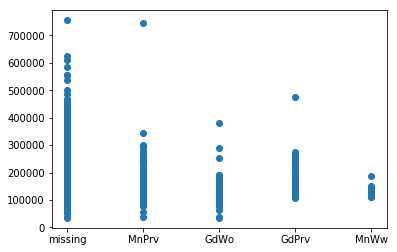

In [11]:
# check correlation between NaN cols with sale prices

plt.scatter(df_all['Fence'],df_all['SalePrice'])

In [12]:
# drop cols with no strong correlations with price
cols_high_na=['MiscFeature','Alley','Fence']
df_all.drop(cols_high_na,axis=1,inplace=True)

In [13]:
# check percentage of zeros 
zeros_cols = ((df_all==0).sum()/len(df_all))
zeros_cols = zeros_cols[zeros_cols>0]
print(zeros_cols.sort_values(ascending=False))

HasPool          0.995546
Has3SsnPorch     0.987324
LowQualFinSF     0.986297
MiscVal          0.964714
ScreenPorch      0.912299
BsmtFinSF2       0.881124
EnclosedPorch    0.842754
MasVnrArea       0.603289
2ndFlrSF         0.571429
BsmtFullBath     0.531689
WoodDeckSF       0.521754
Fireplaces       0.486468
OpenPorchSF      0.444673
BsmtFinSF1       0.318602
BsmtUnfSF        0.082905
GarageArea       0.054128
GarageCars       0.054128
TotalBsmtSF      0.027064
BedroomAbvGr     0.002741
KitchenAbvGr     0.001028
FullBath         0.001028
dtype: float64


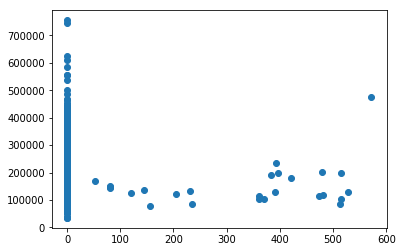

In [14]:
plt.scatter(df_all['LowQualFinSF'],df_all['SalePrice'])

In [15]:
frac_zeros = ((df_all==0).sum()/len(df_all))
# no. unique values in each column
n_unique = df_all.nunique()

# difference between frac. zeros and expected
# frac. zeros if values evenly distributed between
# classes
xs_zeros = frac_zeros - 1/n_unique

# create dataframe and display which columns may be problematic
zero_cols = pd.DataFrame({'frac_zeros':frac_zeros,'n_unique':n_unique,'xs_zeros':xs_zeros})
zero_cols = zero_cols[zero_cols.frac_zeros>0]
zero_cols.sort_values(by='xs_zeros',ascending=False,inplace=True)
display(zero_cols[(zero_cols.xs_zeros>0)])

,frac_zeros,n_unique,xs_zeros
LowQualFinSF,0.986297,36,0.958519
MiscVal,0.964714,38,0.938398
ScreenPorch,0.912299,121,0.904034
BsmtFinSF2,0.881124,272,0.877447
EnclosedPorch,0.842754,183,0.837290
MasVnrArea,0.603289,444,0.601037
2ndFlrSF,0.571429,635,0.569854
WoodDeckSF,0.521754,379,0.519116
HasPool,0.995546,2,0.495546
Has3SsnPorch,0.987324,2,0.487324


In [16]:
dummy_cols = zero_cols[(zero_cols.xs_zeros>0)].index
for col in dummy_cols:
    df_all['Has'+col] = (df_all[col]>0).astype(int)

In [17]:
#get numeric columns

In [19]:
'''df_all['TotalBsmtSF'] = df_all['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
df_all['2ndFlrSF'] = df_all['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
df_all['GarageArea'] = df_all['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
df_all['GarageCars'] = df_all['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
df_all['LotFrontage'] = df_all['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
#df_all['MasVnrArea'] = df_all['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
df_all['BsmtFinSF1'] = df_all['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)'''

"df_all['TotalBsmtSF'] = df_all['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)\ndf_all['2ndFlrSF'] = df_all['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)\ndf_all['GarageArea'] = df_all['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)\ndf_all['GarageCars'] = df_all['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)\ndf_all['LotFrontage'] = df_all['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)\n#df_all['MasVnrArea'] = df_all['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)\ndf_all['BsmtFinSF1'] = df_all['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)"

In [18]:
df_all_num=[]
for col in df_all.columns:
    if df_all[col].dtype.name!='object':
        df_all_num.append(col)

In [19]:
df_all_cat=[]
for col in df_all.columns:
    if df_all[col].dtype.name=='object':
        df_all_cat.append(col)

In [20]:
df_all[df_all_cat].head(2)

,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,Electrical,...,MSZoning,MasVnrType,Neighborhood,PavedDrive,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities
Id,,,,,,,,,,,,,,,,,,,,,
1,1Fam,TA,No,GLQ,Unf,Gd,Y,Norm,Norm,SBrkr,...,RL,BrkFace,CollgCr,Y,CompShg,Gable,Normal,WD,Pave,AllPub
2,1Fam,TA,Gd,ALQ,Unf,Gd,Y,Feedr,Norm,SBrkr,...,RL,None,Veenker,Y,CompShg,Gable,Normal,WD,Pave,AllPub


In [21]:
#transform numeric data

In [22]:
cols_with_na = df_all.drop('SalePrice',axis=1).isnull().sum()
cols_with_na = cols_with_na[cols_with_na>0]
print(cols_with_na.sort_values(ascending=False))

LotFrontage    486
GarageYrBlt    159
dtype: int64


In [23]:
df_all.loc[df_all.GarageYrBlt.isnull(),'GarageYrBlt'] = df_all.loc[df_all.GarageYrBlt.isnull(),'YearBuilt']

In [24]:
'''df_all["LotFrontage"] = df_all.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))'''

'df_all["LotFrontage"] = df_all.groupby("Neighborhood")["LotFrontage"].transform(\n    lambda x: x.fillna(x.median()))'

In [25]:
df=pd.get_dummies(df_all)
test_LotFrontage=df.loc[df.LotFrontage.isna()]
train_LotFrontage=df.loc[df.LotFrontage.notna()]
X_train,y_train=train_LotFrontage.drop(['LotFrontage','SalePrice'],axis=1),train_LotFrontage['LotFrontage']
X_test,y_test=test_LotFrontage.drop(['LotFrontage','SalePrice'],axis=1),test_LotFrontage['LotFrontage']
lr=linear_model.Ridge().fit(X_train,y_train)
y_=lr.predict(X_test)
y_test=pd.Series(y_)

j=0
for i in test_LotFrontage.index:
    df_all.set_value(i,'LotFrontage',y_[j])
    j+=1

In [26]:
#removing outliers

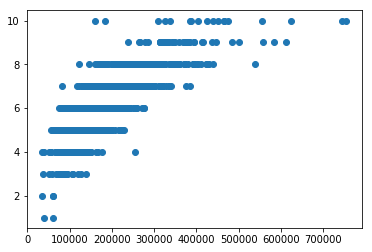

In [27]:
plt.scatter(df_all['SalePrice'],df_all['OverallQual'])

In [28]:
df_all.drop(df_all[(df_all['OverallQual']<5) & (df_all['SalePrice']>200000)].index, inplace=True)

In [29]:
#df_all.drop(df_all[(df_all['OverallQual']>9) & (df_all['SalePrice']<200000)].index, inplace=True)

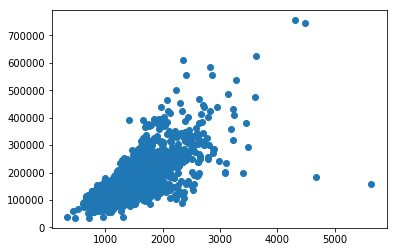

In [30]:
plt.scatter(df_all['GrLivArea'],df_all['SalePrice'])

In [31]:
df_all.drop(df_all[(df_all["GrLivArea"]>4000)&(df_all["SalePrice"]<300000)].index,inplace=True)

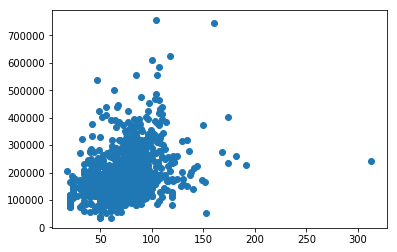

In [32]:
plt.scatter(df_all['LotFrontage'],df_all['SalePrice'])

In [33]:
for index,row in df_all.iterrows():
    if (row['LotFrontage']>300) & (row['SalePrice']<300000):
        df_all.set_value(index, 'LotFrontage', df_all['LotFrontage'].mode()[0])
    elif (row['LotFrontage']>150) & (row['SalePrice']<100000):
        df_all.set_value(index, 'LotFrontage', 80)

In [34]:
'''for index,row in df_all.iterrows():
    if (row['GrLivArea']>4000) & (row['SalePrice']<200000):
        df_all.set_value(index, 'GrLivArea', df_all['GrLivArea'].mode()[0])'''

"for index,row in df_all.iterrows():\n    if (row['GrLivArea']>4000) & (row['SalePrice']<200000):\n        df_all.set_value(index, 'GrLivArea', df_all['GrLivArea'].mode()[0])"

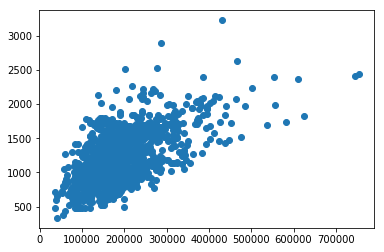

In [35]:
plt.scatter(df_all['SalePrice'],df_all['1stFlrSF'])

In [36]:
#df_all.drop(df_all[(df_all["SalePrice"]>700000)].index,inplace=True)

In [37]:
'''for index,row in df_all.iterrows():
    if (row['1stFlrSF']>3000) & (row['SalePrice']<200000):
        df_all.set_value(index, '1stFlrSF', 1800)'''

"for index,row in df_all.iterrows():\n    if (row['1stFlrSF']>3000) & (row['SalePrice']<200000):\n        df_all.set_value(index, '1stFlrSF', 1800)"

In [38]:
df_all['TotArea']=df_all['1stFlrSF']+df_all['2ndFlrSF']+df_all['TotalBsmtSF']
df_all=df_all.drop(['1stFlrSF','2ndFlrSF','TotalBsmtSF'],axis=1)

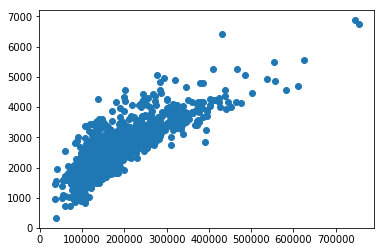

In [39]:
plt.scatter(df_all['SalePrice'],df_all['TotArea'])

In [42]:
#plt.scatter(df_all['SalePrice'],df_all['2ndFlrSF'])

In [40]:
df_all["TotalPlace"] =( df_all["TotArea"] + df_all["GarageArea"] + df_all["OpenPorchSF"])* df_all["OverallQual"]
df_all["PorchQual"] = df_all["OpenPorchSF"] * df_all["OverallQual"]
df_all["TotArea"] = df_all["TotArea"] * df_all["OverallQual"]
df_all['ToT']=(df_all['TotArea']+df_all['GrLivArea']+df_all["BsmtFinSF2"] +df_all['GarageArea']+df_all['BsmtFinSF1'])*df_all['OverallQual']
df_all['BsmtFinSF1Qual']=df_all['BsmtFinSF1']*df_all['OverallQual']
#df_all=df_all.drop(['TotArea','GrLivArea','GarageArea','OverallQual'],axis=1)
df_all["Bsmt"] =( df_all["BsmtFinSF1"] + df_all["BsmtUnfSF"])* df_all["OverallQual"]
df_all["Rooms"] = (df_all["FullBath"]+df_all["TotRmsAbvGrd"])* df_all["OverallQual"]
df_all["LotArea"] = df_all["LotArea"] * df_all["OverallQual"]

In [41]:
df_all.drop(['BsmtFinSF2'],axis=1,inplace=True)

In [45]:
#df_all=df_all.drop(['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF'],axis=1)

In [46]:
#plt.scatter(df_all['ToT'],df_all['SalePrice'])

In [42]:
(df_all["ToT"] ).corr(df_all['SalePrice'])

0.9256692433689366

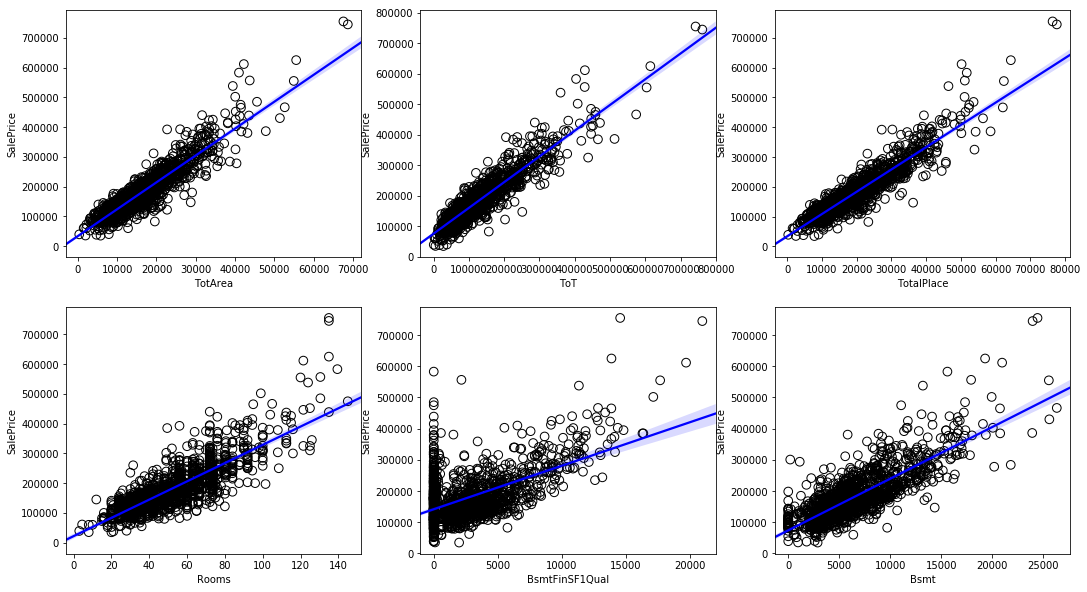

In [43]:
import seaborn as sns
plt.figure(figsize=(18,10))
features=['TotArea','ToT','TotalPlace','Rooms','BsmtFinSF1Qual','Bsmt']
for i in range(len(features)):
    ii = '23'+str(i+1)
    plt.subplot(ii)
    plt.scatter(df_all[features[i]], df_all['SalePrice'], facecolors='none',edgecolors='k',s = 75)
    sns.regplot(x = features[i], y = 'SalePrice', data = df_all,scatter=False, color = 'Blue')

In [49]:
#dummies cat data

In [44]:
df_all_num=[]
for col in df_all.columns:
    if df_all[col].dtype.name!='object':
        df_all_num.append(col)

In [45]:
'''from scipy.stats import skew
df_all_num=df_all_num
df_numeric=df_all[df_all_num]
#f_numeric=np.log1p(df_all[df_all_num])
skewed_feats = df_numeric.apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
df_numeric[skewed_feats] = np.log1p(df_numeric[skewed_feats])
df_numeric[skewed_feats] = df_numeric[skewed_feats].fillna(df_numeric[skewed_feats].mean())
#df_numeric['SalePrice']=np.log(df_numeric['SalePrice'])
#len(df_numeric[df_numeric==0])
df_numeric.head(2)'''
loglist = ['SalePrice','LotFrontage','LotArea','BsmtFinSF1','BsmtUnfSF',
                 'TotalPlace','TotArea','ToT','GrLivArea',
                 'BsmtFullBath','FullBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'YearRemodAdd','BsmtFinSF1Qual','Bsmt','Rooms']
df_all_num=df_all_num
num_no_scale=[item for item in df_all_num if item not in loglist]
#df_numeric=df_all[num_no_scale]
df_numeric=pd.concat([np.log1p(df_all[loglist]),df_all[num_no_scale]],axis=1)
#df_numeric=df_numeric.drop
#df_numeric['SalePrice']=np.log(df_numeric['SalePrice'])
#len(df_numeric[df_numeric==0])
df_numeric.head(2)

,SalePrice,LotFrontage,LotArea,BsmtFinSF1,BsmtUnfSF,TotalPlace,TotArea,ToT,GrLivArea,BsmtFullBath,...,HasHasPool,HasHas3SsnPorch,HasOpenPorchSF,HasBsmtFullBath,HasBsmtFinSF1,HasFireplaces,HasBsmtUnfSF,HasGarageArea,HasTotalBsmtSF,PorchQual
Id,,,,,,,,,,,,,,,,,,,,,
1,12.247699,4.189655,10.987849,6.561031,5.017280,10.009018,9.796069,11.894665,7.444833,0.693147,...,0,0,1,1,1,0,1,1,1,427
2,12.109016,4.394449,10.961295,6.886532,5.652489,9.792835,9.625426,11.581191,7.141245,0.405465,...,0,0,0,1,1,1,1,1,1,0


In [46]:
#df_numeric['BsmtFinSF1']=df_numeric['BsmtFinSF1'].replace(8,7)

In [47]:
df_cat=df_all[df_all_cat]

In [54]:
'''different way to deal with cateories data'''

'different way to deal with cateories data'

In [55]:
'''for column in df_cat.columns:
    df_cat[column] = pd.Categorical(df_cat[column]).codes'''

'for column in df_cat.columns:\n    df_cat[column] = pd.Categorical(df_cat[column]).codes'

In [48]:
df_cat=pd.get_dummies(df_cat)

In [49]:
df_cat.head(2)

,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_missing,...,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa
Id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,1,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,1,0


In [50]:
corr=[]
for column in df_cat.columns:
    corr.append([column,abs(df_numeric['SalePrice'].corr(df_cat[column]))])
corr=pd.DataFrame(corr)
corr.columns=['ColumnName','SalePrice']
corr=corr.sort_values(['SalePrice'], ascending=[0])

In [51]:
corr.head(5)

,ColumnName,SalePrice
66,ExterQual_TA,0.597368
162,KitchenQual_TA,0.538177
106,Foundation_PConc,0.532205
65,ExterQual_Gd,0.510752
103,FireplaceQu_missing,0.509913


In [58]:
#df_cat=df_cat.drop(['Condition2','MasVnrType','GarageQual','BsmtFinType2','Utilities'],axis=1)

In [89]:
#df_cat=pd.get_dummies(df_cat)

In [58]:
#df_cat.head(2)

In [56]:
frac_zeros = ((df_model==0).sum()/len(df_model))
# no. unique values in each column
n_unique = df_model.nunique()

# difference between frac. zeros and expected
# frac. zeros if values evenly distributed between
# classes
xs_zeros = frac_zeros - 1/n_unique

# create dataframe and display which columns may be problematic
zero_cols = pd.DataFrame({'frac_zeros':frac_zeros,'n_unique':n_unique,'xs_zeros':xs_zeros})
zero_cols = zero_cols[zero_cols.frac_zeros>0]
zero_cols.sort_values(by='frac_zeros',ascending=False,inplace=True)
display(zero_cols[(zero_cols.xs_zeros>0)])

,frac_zeros,n_unique,xs_zeros
Utilities_NoSeWa,0.999657,2,0.499657
Heating_Floor,0.999657,2,0.499657
RoofMatl_Metal,0.999657,2,0.499657
RoofMatl_Membran,0.999657,2,0.499657
Condition2_RRAe,0.999657,2,0.499657
Condition2_RRAn,0.999657,2,0.499657
Electrical_Mix,0.999657,2,0.499657
Exterior1st_ImStucc,0.999657,2,0.499657
Exterior2nd_Other,0.999657,2,0.499657
RoofMatl_Roll,0.999657,2,0.499657


In [57]:
zero_cols[100:101]

,frac_zeros,n_unique,xs_zeros
SaleCondition_Family,0.984225,2,0.484225


In [58]:
df_model5=df_model.drop(list(zero_cols.index)[0:100],axis=1)

In [64]:
df_model6=df_model[(df_model2.columns).intersection(df_model5.columns)]

In [55]:
df_model=pd.concat([df_numeric,df_cat],axis=1)

In [60]:
lasso=linear_model.Lasso(alpha=0.001)
X,y=df_model[0:1457].drop(['SalePrice'],axis=1).values,(df_model['SalePrice'][0:1457]).values
lasso.fit(X,y)
FI_lasso = pd.DataFrame({"Feature Importance":abs(lasso.coef_)}, index=df_model.drop(['SalePrice'],axis=1).columns)
FI_lasso=FI_lasso.sort_values("Feature Importance",ascending=False)

In [61]:
df_model2=df_model.drop(list(FI_lasso.index)[73:],axis=1)

In [62]:
df_model3=df_model.drop(list(FI_lasso.index)[150:],axis=1)

In [63]:
df_model4=df_model.drop(list(FI_lasso.index)[60:],axis=1)

In [ ]:
'''import seaborn as sns
%matplotlib inline
df_corr = df_model.loc[id_train, df_model.columns].corr(method='spearman').abs()
df_corr = df_corr.sort_values('SalePrice',axis=0,ascending=False).sort_values('SalePrice',axis=1,ascending=False)
ax=plt.figure(figsize=(20,16)).gca()
sns.heatmap(df_corr,ax=ax,square=True)'''

In [ ]:
#df_corr.head(5)

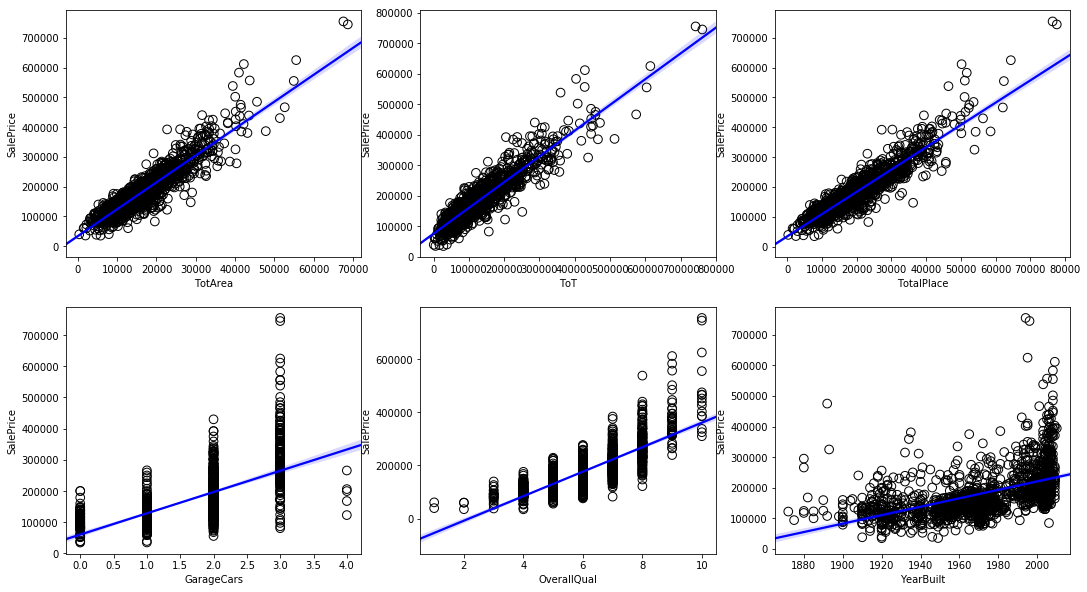

In [65]:
plt.figure(figsize=(18,10))
features=['TotArea','ToT','TotalPlace','GarageCars','OverallQual','YearBuilt']
#features=['TotArea','OverallQual','GrLivArea','GarageCars','FullBath','YearBuilt','GarageArea','ExterQual','GarageYrBlt']
for i in range(len(features)):
    ii = '23'+str(i+1)
    plt.subplot(ii)
    plt.scatter(df_all[features[i]], df_all['SalePrice'], facecolors='none',edgecolors='k',s = 75)
    sns.regplot(x = features[i], y = 'SalePrice', data = df_all,scatter=False, color = 'Blue')
#ax=plt.gca() 
#ax.set_ylim([0,800000])

In [66]:
len(df_model)

2916

In [67]:
#models
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
def predict_data(df_model,mod):
    df_model=df_model.reset_index()
    X,y=df_model[0:1457].drop(['SalePrice'],axis=1).values,(df_model['SalePrice'][0:1457]).values
    X_test,y_test =df_model[1457:].drop(['SalePrice'],axis=1).values,(df_model['SalePrice'][1457:]).values
    # create cross-validation method
    kf = KFold(n_splits=20) # Define the split - into 20 folds 
    kf.get_n_splits(X)
    min_e=np.Inf
    pred=0
    train_pred=0
    rmse_score=0
    random_state = 1234
    rkf = RepeatedKFold(n_splits=30, n_repeats=6, random_state=random_state)
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model=mod.fit(X_train, y_train)
        y_pred=mod.predict(X_test)
        if np.sqrt(np.mean((np.log(1+np.exp(y_pred)) - np.log(1+np.exp(y_test)))**2))<min_e:
            min_e=np.sqrt(np.mean((np.log(1+np.exp(y_pred)) - np.log(1+np.exp(y_test)))**2))
            rmse_score=np.sqrt(np.mean((np.log(1+np.exp(y_pred)) - np.log(1+np.exp(y_test)))**2))
            X_test=df_model[1457:].drop(['SalePrice'],axis=1).values
            pred=model.predict(X_test)
            pred = np.exp(pred)
            train_pred=model.predict(X)
            train_pred = pd.concat([pd.DataFrame(np.exp(train_pred)),pd.DataFrame(np.exp(y))],axis=1)
            train_pred.columns = ['Predictions','SalePrice']
            #pred=[int(item) for item in pred]
            pred = pd.DataFrame(pred,index=range(1461,2920))
            pred.columns = ['SalePrice']
        
    return pred,rmse_score,train_pred

In [66]:
#df_model.drop(df_model[(np.exp(df_model["SalePrice"])>700000)].index,inplace=True)

In [68]:
#gbr.to_csv('gbr22222220000.csv')

In [68]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

In [69]:
myGBR = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.02,
                                      max_depth=4, max_features='sqrt',
                                      min_samples_leaf=15, min_samples_split=50,
                                      loss='huber', random_state = 3) 
gbr,rmg,modg=predict_data(df_model,myGBR)

In [70]:
rmg

0.06104124575010423

In [71]:
gbr.head(5)

,SalePrice
1461,125954.635801
1462,156120.001299
1463,189525.683050
1464,195417.044059
1465,187111.177127


In [71]:
myGBR = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.02,
                                      max_depth=4, max_features='sqrt',
                                      min_samples_leaf=15, min_samples_split=50,
                                      loss='huber', random_state = 3) 
gbr2,rmg,modg2=predict_data(df_model2,myGBR)

In [72]:
rmg

0.0581175382276603

In [75]:
gbr2.head(5)

,SalePrice
1461,130161.769870
1462,155998.832724
1463,189484.287609
1464,201717.529412
1465,186457.510055


In [335]:
myGBR = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.02,
                                      max_depth=4, max_features='sqrt',
                                      min_samples_leaf=15, min_samples_split=50,
                                      loss='huber', random_state = 3) 
gbr3,rmg,modg3=predict_data(df_model3,myGBR)

In [338]:
gbr3.head(5)

,SalePrice
1461,129899.983121
1462,158252.312842
1463,187686.839357
1464,200075.244411
1465,187176.597284


In [337]:
myGBR = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.02,
                                      max_depth=4, max_features='sqrt',
                                      min_samples_leaf=15, min_samples_split=50,
                                      loss='huber', random_state = 3) 
gbr4,rmg,modg4=predict_data(df_model4,myGBR)

In [339]:
gbr4.head(5)

,SalePrice
1461,130521.044206
1462,159456.290714
1463,186962.200137
1464,201852.932602
1465,182486.794318


In [507]:
myGBR = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.02,
                                      max_depth=4, max_features='sqrt',
                                      min_samples_leaf=15, min_samples_split=50,
                                      loss='huber', random_state = 5) 
gbr5,rmg,modg5=predict_data(df_model5,myGBR)

In [508]:
rmg

0.06091554554007617

In [509]:
gbr5.head(5)

,SalePrice
1461,125792.186140
1462,157164.260202
1463,186946.920001
1464,194868.363349
1465,185698.012299


In [531]:
myGBR = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.02,
                                      max_depth=4, max_features='sqrt',
                                      min_samples_leaf=15, min_samples_split=50,
                                      loss='huber', random_state = 5) 
gbr6,rmg,modg5=predict_data(df_model6,myGBR)

In [532]:
rmg

0.06190212595334206

In [533]:
gbr6.head(5)

,SalePrice
1461,129648.404508
1462,155632.367401
1463,187748.983155
1464,199798.385422
1465,188996.221233


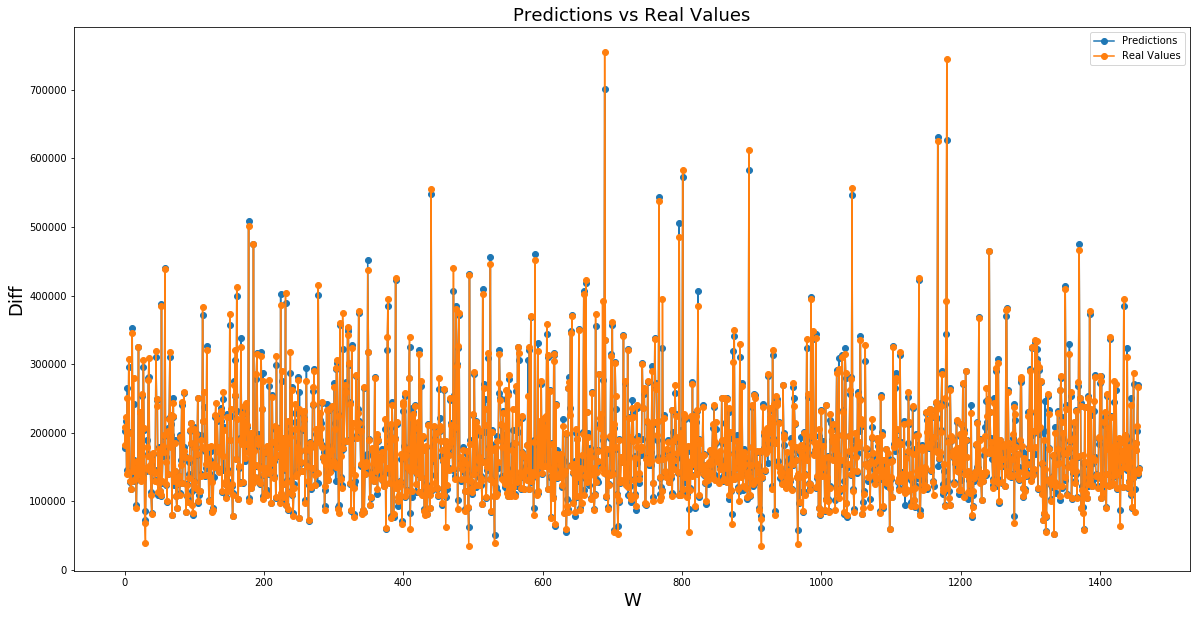

In [85]:
plt.figure(figsize=(20,10))
plt.plot([( row['Predictions'],row['SalePrice']
              ) for index, row in modg.iterrows()], 'o-')
plt.xlabel('W', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('Predictions vs Real Values', fontsize=18)
plt.legend(['Predictions','Real Values'], fontsize=10, loc='upperleft')
plt.show()

In [80]:
lasso1 = make_pipeline(RobustScaler(), linear_model.Lasso(alpha =0.0008))
p,rm,mod=predict_data(df_model,lasso1)

In [81]:
rm

0.06821189583207474

In [82]:
p.head(5)

,SalePrice
1461,116360.693449
1462,147798.410493
1463,179439.761744
1464,194784.505290
1465,193495.611800


In [83]:
lasso1 = make_pipeline(RobustScaler(), linear_model.Lasso(alpha =0.0008))
p2,rm,mod2=predict_data(df_model2,lasso1)

In [84]:
rm

0.06359670044237191

In [85]:
p2.head(5)

,SalePrice
1461,116130.787777
1462,149738.063079
1463,178195.719834
1464,193230.830749
1465,195148.390391


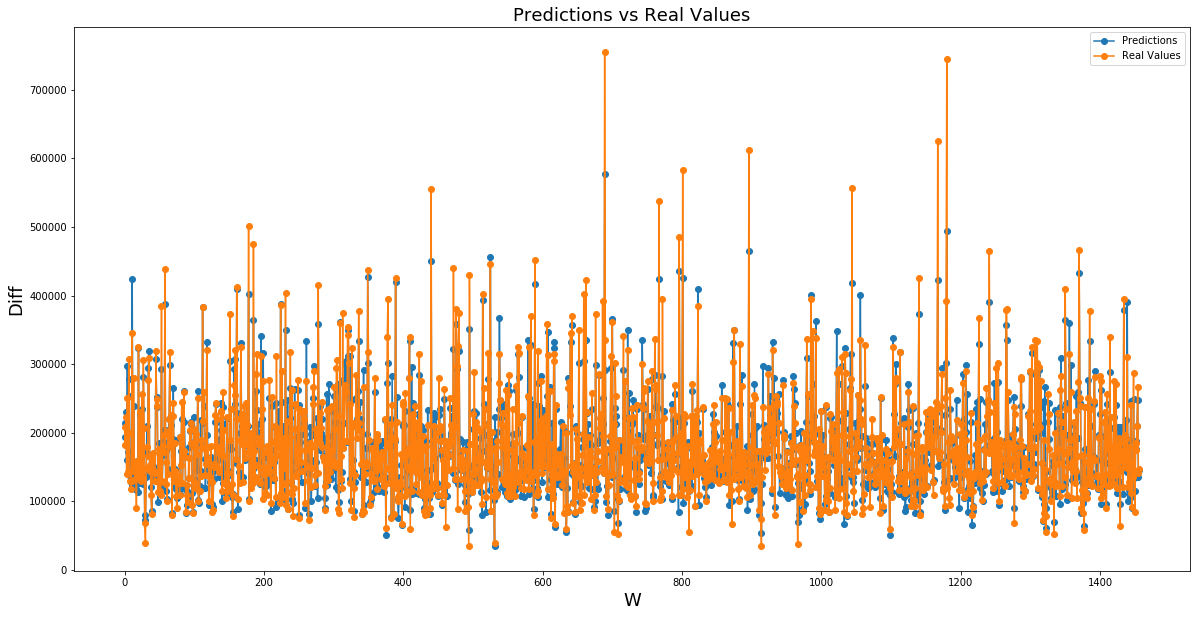

In [139]:
plt.figure(figsize=(20,10))
plt.plot([( row['Predictions'],row['SalePrice']
              ) for index, row in mod.iterrows()], 'o-')
plt.xlabel('W', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('Predictions vs Real Values', fontsize=18)
plt.legend(['Predictions','Real Values'], fontsize=10, loc='upperleft')
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.plot([( row['Predictions']-row['SalePrice']
              ) for index, row in mod.iterrows()], 'o-')
plt.xlabel('W', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('Predictions vs Real Values', fontsize=18)
plt.legend(['Errors'], fontsize=10, loc='upperleft')
plt.show()

In [ ]:
np.exp(p).head(7)

In [86]:
lin = make_pipeline(RobustScaler(), linear_model.LinearRegression())

In [87]:
pLL,rmL,modL=predict_data(df_model,lin)

In [88]:
rmL

0.06843045846009017

In [89]:
pLL.head(5)

,SalePrice
1461,117936.747608
1462,156966.901170
1463,186972.168361
1464,197704.140436
1465,196610.931669


In [90]:
pLL2,rmL,modL=predict_data(df_model2,lin)

In [91]:
rmL

0.06442397641644287

In [92]:
pLL2.head(7)

,SalePrice
1461,115382.471541
1462,153686.887485
1463,178016.982302
1464,190881.370278
1465,200706.544572
1466,169109.313251
1467,172644.854018


In [93]:
L,rmL,mL=predict_data(df_model,linear_model.Ridge(alpha=0.0008))

In [94]:
rmL

0.06835456465408046

In [95]:
L.head(5)

,SalePrice
1461,117941.500180
1462,157019.466151
1463,186974.758019
1464,197717.326184
1465,196620.745703


In [96]:
L2,rmL,mL2=predict_data(df_model2,linear_model.Ridge(alpha=0.0008))

In [97]:
rmL

0.06442327240933604

In [98]:
L2.head(5)

,SalePrice
1461,115381.104750
1462,153686.548250
1463,178017.446046
1464,190882.205348
1465,200705.974562


In [99]:
ENet = make_pipeline(RobustScaler(), linear_model.ElasticNet(alpha=0.0009, l1_ratio=0.005))
pE,rmE,m=predict_data(df_model,ENet)

In [100]:
rmE

0.06467766694015607

In [101]:
pE.head(5)

,SalePrice
1461,116013.511720
1462,154418.913579
1463,184817.975667
1464,195218.494416
1465,196975.718229


In [102]:
ENet = make_pipeline(RobustScaler(), linear_model.ElasticNet(alpha=0.0009, l1_ratio=0.005))
pE2,rmE,m=predict_data(df_model2,ENet)

In [103]:
rmE

0.0641577954905535

In [104]:
pE2.head(5)

,SalePrice
1461,114761.817796
1462,153556.777389
1463,178145.116417
1464,191176.776906
1465,199730.427074


In [ ]:
plt.figure(figsize=(20,10))
plt.plot([( row['Predictions'],row['SalePrice']
              ) for index, row in mod.iterrows()], 'o-')
plt.xlabel('W', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('Predictions vs Real Values', fontsize=18)
plt.legend(['Predictions','Real Values'], fontsize=10, loc='upperleft')
plt.show()

In [105]:
pR,rmR,mK=predict_data(df_model,KernelRidge(alpha=19.0001, degree=2, coef0=3))

In [106]:
rmR

0.0697327217852304

In [107]:
pR.head(5)

,SalePrice
1461,118406.074221
1462,157997.581926
1463,181279.258921
1464,197034.438817
1465,194416.217869


In [108]:
pR2,rmR,mK=predict_data(df_model2,KernelRidge(alpha=19.0001, degree=2, coef0=3))

In [109]:
rmR

0.06530876304593275

In [110]:
pR2.head(5)

,SalePrice
1461,119648.761479
1462,153276.422522
1463,180379.396423
1464,196800.733623
1465,197128.361534


In [ ]:
plt.figure(figsize=(20,10))
plt.plot([( row['Predictions'],row['SalePrice']
              ) for index, row in mK.iterrows()], 'o-')
plt.xlabel('W', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('Predictions vs Real Values', fontsize=18)
plt.legend(['Predictions','Real Values'], fontsize=10, loc='upperleft')
plt.show()

In [111]:
pBR,rmB,mBR=predict_data(df_model,linear_model.ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.00002000000000001,0.0008,19.0001], 
                           cv = 3))

In [112]:
rmB

0.06807301604126349

In [113]:
pBR.head(5)

,SalePrice
1461,116667.614210
1462,152002.586197
1463,178688.905367
1464,192381.072894
1465,196009.879137


In [114]:
pBR2,rmB,mBR=predict_data(df_model2,linear_model.ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.00002000000000001,0.0008,19.0001], 
                           cv = 3))

In [115]:
rmB

0.06373102801523808

In [116]:
pBR2.head(5)

,SalePrice
1461,115246.644562
1462,152988.044277
1463,178368.819953
1464,191848.596733
1465,199500.754213


In [ ]:
plt.figure(figsize=(20,10))
plt.plot([( row['Predictions'],row['SalePrice']
              ) for index, row in mBR.iterrows()], 'o-')
plt.xlabel('W', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('Predictions vs Real Values', fontsize=18)
plt.legend(['Predictions','Real Values'], fontsize=10, loc='upperleft')
plt.show()

In [642]:
ll=pd.read_csv('fn3.csv')

In [643]:
ll.index=range(1461,2920)

In [ ]:
ll.head(6)

In [806]:
all_predict=pd.concat([gbr,gbr4,gbr3,gbr5,gbr6,p,pE,pR,pBR2,L],axis=1)

In [807]:
#all_predict=all_predict.drop(['Id'],axis=1)

In [808]:
all_predict.head(7)

,SalePrice,SalePrice,SalePrice,SalePrice,SalePrice,SalePrice,SalePrice,SalePrice,SalePrice,SalePrice
1461,125954.635801,130521.044206,129899.983121,125792.186140,129648.404508,116360.693449,116013.511720,118406.074221,115246.644562,117941.500180
1462,156120.001299,159456.290714,158252.312842,157164.260202,155632.367401,147798.410493,154418.913579,157997.581926,152988.044277,157019.466151
1463,189525.683050,186962.200137,187686.839357,186946.920001,187748.983155,179439.761744,184817.975667,181279.258921,178368.819953,186974.758019
1464,195417.044059,201852.932602,200075.244411,194868.363349,199798.385422,194784.505290,195218.494416,197034.438817,191848.596733,197717.326184
1465,187111.177127,182486.794318,187176.597284,185698.012299,188996.221233,193495.611800,196975.718229,194416.217869,199500.754213,196620.745703
1466,174862.650012,171827.236224,174037.570471,175922.833653,174886.481373,172475.554030,170907.148375,171645.375749,169381.597598,171280.406008
1467,174589.153754,173779.941777,170417.213369,176571.846913,172994.427305,179633.950297,174096.549085,174047.505272,173469.156967,175507.811463


In [809]:
#all_predict.columns=['GBR','GBR2','g3','g4','g5','g6','p','p2','pE','pR','pBR','pBR2']

In [892]:
f=[]
for index,row in all_predict.iterrows():
    f.append(np.mean(row))
f=pd.DataFrame(f)
f.columns=['SalePrice']
f.index=range(1461,2920)
f.loc[2550]=393091.256352

In [893]:
np.sqrt(mean_squared_error(f,mm.SalePrice))

6410.195687907376

In [894]:
f[0:3]

,SalePrice
1461,122578.467791
1462,155684.764888
1463,184975.120000


In [907]:
(ll.SalePrice+f.SalePrice)/2

1461    122572.706795
1462    155241.035141
1463    184535.283117
1464    196690.243154
1465    191185.262669
1466    172690.523342
1467    174561.911557
1468    164231.271063
1469    193523.242512
1470    118778.175440
1471    193573.293220
1472     97138.759761
1473     96916.724611
1474    148902.755427
1475    111601.972838
1476    362265.940321
1477    247499.769240
1478    299001.978184
1479    283955.501415
1480    512323.590373
1481    320803.778252
1482    208793.639252
1483    176776.960221
1484    163621.439266
1485    181818.942880
1486    194774.400530
1487    335068.785650
1488    231880.019412
1489    200028.738094
1490    231633.067507
            ...      
2890     81038.818046
2891    135482.445027
2892     47604.063430
2893     87507.273141
2894     57504.704364
2895    342868.898262
2896    286042.987079
2897    206699.592065
2898    143566.891867
2899    208182.340541
2900    158626.087288
2901    212637.368910
2902    184474.649333
2903    322112.480916
2904    35

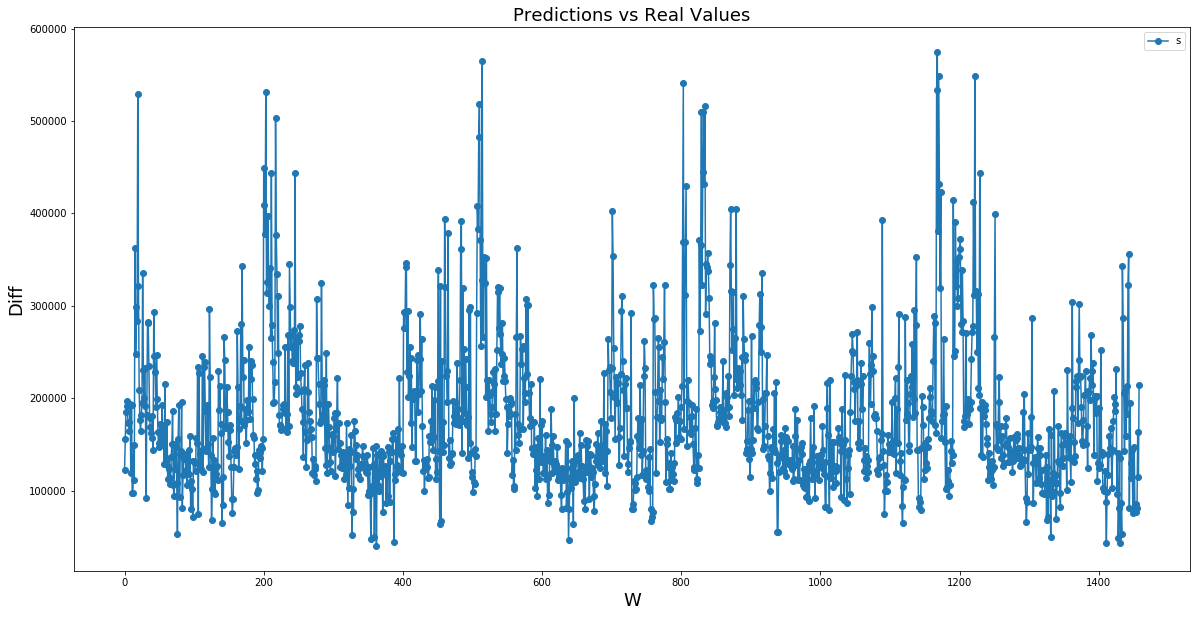

In [904]:
plt.figure(figsize=(20,10))
plt.plot([( row['SalePrice']
              ) for index, row in f.iterrows()], 'o-')
plt.xlabel('W', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('Predictions vs Real Values', fontsize=18)
plt.legend(['s'], fontsize=10, loc='upperleft')
plt.show()

In [896]:
import math
def percentile(data, percentile):
    size = len(data)
    return sorted(data)[int(math.ceil((size * percentile) / 100)) - 1]

p25 = percentile(f.SalePrice, 1)
p75 = percentile(f.SalePrice, 99)
p50 = percentile(f.SalePrice, 50)

In [897]:
p25

63617.363133686595

In [898]:
p75

449048.8407304956

In [899]:
min(f.SalePrice)

47873.89485309424

In [900]:
max(f.SalePrice)

542957.1416230497

In [901]:
f[f.SalePrice>449048.8407304956]=f[f.SalePrice>449048.8407304956]+32000

In [902]:
f[f.SalePrice<63617.363133686595]=f[f.SalePrice<63617.363133686595]-8000

In [911]:
np.sqrt(mean_squared_error(f,mm.SalePrice))

6112.414007440447

In [694]:
f.loc[2550]=393091.256352

In [691]:
f=pd.DataFrame(f)

In [692]:
f.columns=['SalePrice']

In [693]:
f.index=range(1461,2920)

In [461]:
ffll=pd.DataFrame((gbr+gbr2+pBR2)/3)

In [466]:
ffll.to_csv('gbrgbr2pBR2.csv')

In [353]:
d = pd.read_csv('final_submission.csv')

In [122]:
ffll.head(7)

,SalePrice
1461,123146.278823
1462,152868.447901
1463,183840.003721
1464,197474.180081
1465,190802.950223
1466,172896.882033
1467,175273.388084


In [528]:
ll=pd.read_csv('fn2.csv')
ll.index=range(1461,2920)

In [585]:
np.sqrt(mean_squared_error(f,mm.SalePrice))

8611.799989802284

In [539]:
#gbr6.set_value(2550,'SalePrice',393091.256352)

In [330]:
#gbr2.set_value(2550,'SalePrice',393091.256352)
#hhkhkb

In [571]:
mm[abs(f.SalePrice-mm.SalePrice)>40000]

,Id,SalePrice
1664,1664,543385.142092
1678,1678,525567.512799
2293,2293,525176.218056
2295,2295,529554.149165


In [569]:
f[abs(f.SalePrice-mm.SalePrice)>40000]

,SalePrice
1664,487349.605960
1678,471211.423533
2293,479251.380044
2295,482406.036272


In [175]:
ff[abs(gbr.SalePrice-ff.SalePrice)>40000]

,Id,SalePrice
1970,1970,426835.224216
2550,2550,484534.400163
2690,2690,429260.654201


In [ ]:
min(f.SalePrice)

In [ ]:
f[f.SalePrice>400000.754441089]

In [ ]:
print(p25)

In [ ]:
ll.head(2)

In [ ]:
#f.set_value(2550,'SalePrice',596740.568529)

In [ ]:
gbr[gbr.SalePrice<60000]=gbr[gbr.SalePrice<60000]-10000

In [ ]:
gbr[gbr.SalePrice>157000]=gbr[gbr.SalePrice>157000]+9000

In [ ]:
print(p75)

In [ ]:
print(p50)

In [ ]:
ffff.to_csv('ffff2.csv')

In [ ]:
l=pd.DataFrame(((pE.SalePrice+ll.SalePrice)/2),columns=['SalePrice'])

In [121]:
mm.index=range(1461,2920)

In [ ]:
f.to_csv('fmean1.csv')

In [120]:
mm=pd.read_csv('House_Prices_submit.csv')

In [ ]:
ll.drop(['Id'],axis=1).to_csv('llmanual7.csv')

In [ ]:
ll.head(10)

In [ ]:
m.head(10)

In [ ]:
df_model=df_model.drop(['Price','Price1','Price2'],axis=1)

In [ ]:
mod.index=range(0,1457)
p.index=range(1458,2917)

In [ ]:
df_model['Price']=np.log1p(mod['Predictions'].append(p['SalePrice']))

In [ ]:
df_model['Price'][0:1457]=np.log1p(mod['Predictions'])
df_model['Price'][1457:]=p['SalePrice']      

In [ ]:
df_model['Price1']=np.log1p(m['Predictions'].append(pE['SalePrice']))
df_model['Price1'][0:1457]=np.log1p(m['Predictions'])
df_model['Price1'][1457:]=pE['SalePrice']      

In [ ]:
df_model.index=range(0,2916)

In [ ]:
#df_model['Price2']=np.log1p(m['Predections'].append(pE['SalePrice']))

In [ ]:
df_model['Price2']=np.log1p(mBR['Predictions'].append(pBR['SalePrice']))
df_model['Price2'][0:1457]=np.log1p(mBR['Predictions'])
df_model['Price2'][1457:]=pBR['SalePrice']      

In [ ]:
#df_model['Price4']=np.log1p(df_train['SalePrice'].append(pR['SalePrice']))

In [487]:
ffff=pd.concat([f.SalePrice,ff.SalePrice],axis=1)

In [488]:
ffff.columns=['llff','mm']

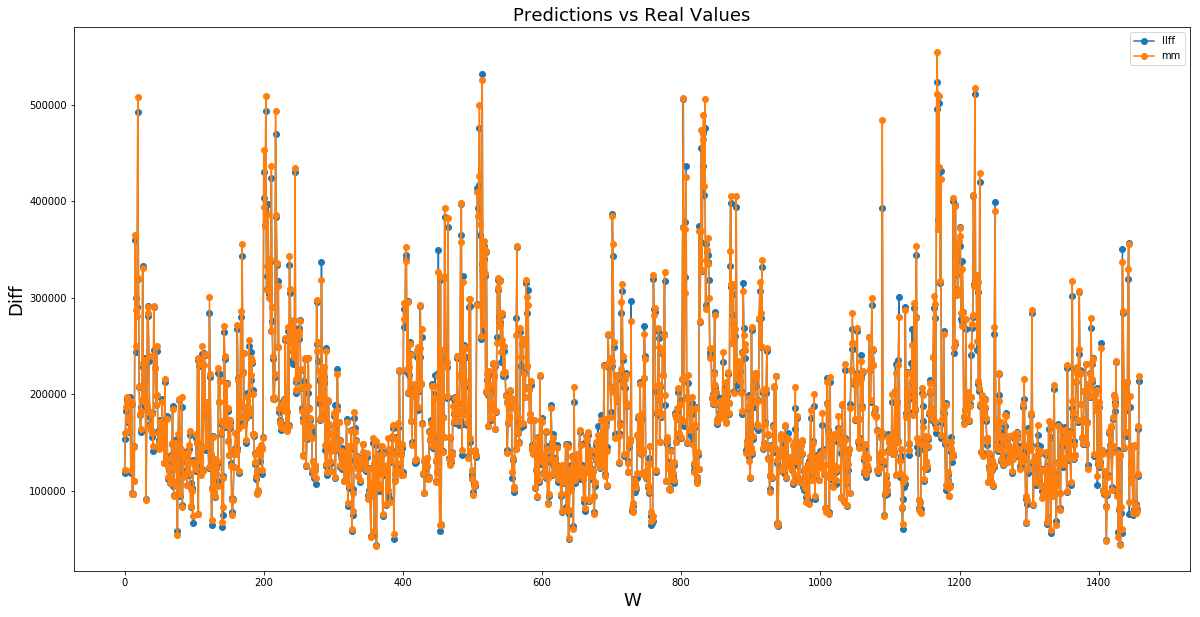

In [489]:
plt.figure(figsize=(20,10))
plt.plot([( row['llff'],row['mm']
              ) for index, row in ffff.iterrows()], 'o-')
plt.xlabel('W', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('Predictions vs Real Values', fontsize=18)
plt.legend(['llff','mm'], fontsize=10, loc='upperleft')
plt.show()

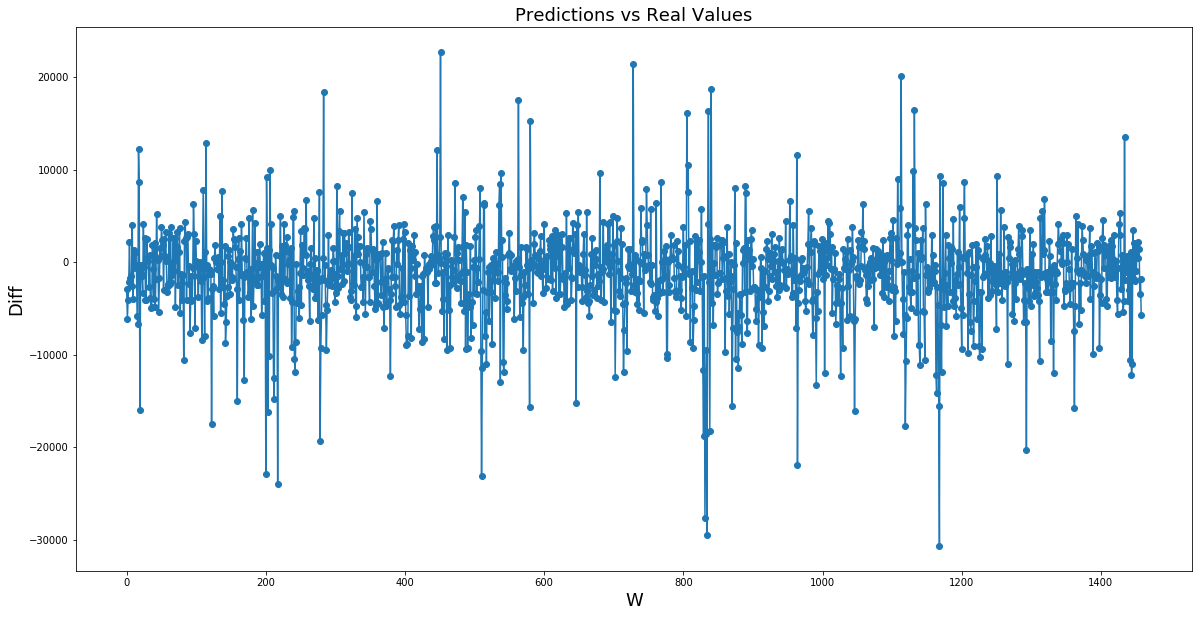

In [495]:
plt.figure(figsize=(20,10))
plt.plot([( row['llff']-row['mm']
              ) for index, row in ffff.iterrows()], 'o-')
plt.xlabel('W', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('Predictions vs Real Values', fontsize=18)
#plt.legend(['Predictions'], fontsize=10, loc='upperleft')
plt.show()

In [496]:
ffff[ffff['mm']-ffff['llff']>20000]

,llff,mm
1661,430347.651120,453229.166031
1678,469374.018424,493323.281185
1971,476290.945258,499448.973350
2292,436918.889818,464621.037065
2295,476494.698037,506018.193582
2425,186152.484365,208054.285698
2629,524245.942504,554949.439485
2754,195426.059029,215714.136213


In [27]:
472724.857951/8

59090.607243875

In [28]:
472724.857951+59090.607243875

531815.465194875

In [32]:
ll[ll.SalePrice>449000]

,Id,SalePrice
1480,1665.000,531815.465195
1664,1872.000,543025.020627
1678,1887.750,505844.582507
1971,2217.375,519584.629407
1975,2221.875,560793.399666
2264,2547.000,553389.229290
2290,2576.250,508402.679795
2293,2579.625,527687.197803
2295,2581.875,519531.317833
2628,2956.500,540524.022978


In [296]:
ffff=ffff.drop(['ll','ff'],axis=1)

In [201]:
np.sqrt(mean_squared_error(ffff.llff,ffff.mm))

5411.453137808097

In [494]:
ffff.set_value(2550,'llff',484534.400163)
#ffff.set_value(2294,'ffll',400591.800697)
'''ffff.set_value(1975,'ffll',552579.754441)
ffff.set_value(2293,'ffll',427661.428061)
ffff.set_value(2600,'ffll',179567.729150)
ffff.set_value(2823,'ffll',328020.030481)'''

"ffff.set_value(1975,'ffll',552579.754441)\nffff.set_value(2293,'ffll',427661.428061)\nffff.set_value(2600,'ffll',179567.729150)\nffff.set_value(2823,'ffll',328020.030481)"

In [388]:
ff=pd.read_csv('f888.csv')
ff.index=range(1461,2920)
#mm.drop(['Unnamed: 0','mm'],axis=1).to_csv('ff44444.csv')

In [238]:
ll=pd.read_csv('l31.csv')
ll.index=range(1461,2920)

In [389]:
ll2=pd.read_csv('llmmff.csv')
ll2.index=range(1461,2920)

In [172]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [905]:
f.to_csv('fn4.csv')

In [70]:
np.min(ffff)

mm    34124.014722
ll    47093.157446
ff    44782.725346
dtype: float64

In [128]:
pg=pd.read_csv('pgbr2.csv')
pg.index=range(1461,2920)